In [5]:
from torchvision.datasets import VOCDetection
import matplotlib.pyplot as plt
from PIL import Image,ImageDraw

In [6]:
IMG_SIZE=448
S=7
C=20


# VOC数据集

In [7]:
voc_ds=VOCDetection(root='./data',year='2012',image_set='train',download=True)

Using downloaded and verified file: ./data\VOCtrainval_11-May-2012.tar
Extracting ./data\VOCtrainval_11-May-2012.tar to ./data


{'annotation': {'folder': 'VOC2012', 'filename': '2008_000028.jpg', 'source': {'database': 'The VOC2008 Database', 'annotation': 'PASCAL VOC2008', 'image': 'flickr'}, 'size': {'width': '500', 'height': '375', 'depth': '3'}, 'segmented': '1', 'object': [{'name': 'car', 'pose': 'Unspecified', 'truncated': '0', 'occluded': '0', 'bndbox': {'xmin': '158', 'ymin': '199', 'xmax': '231', 'ymax': '240'}, 'difficult': '0'}, {'name': 'car', 'pose': 'Frontal', 'truncated': '0', 'occluded': '0', 'bndbox': {'xmin': '47', 'ymin': '202', 'xmax': '94', 'ymax': '238'}, 'difficult': '0'}]}}


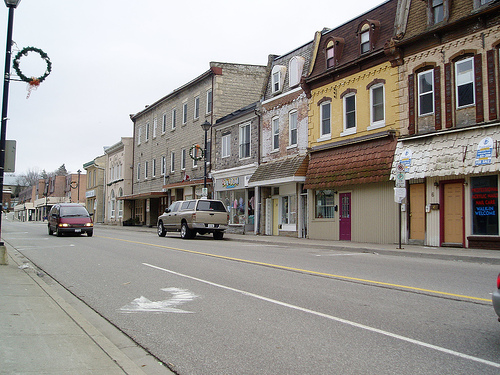

In [8]:
img,label=voc_ds[4]
print(label)
img

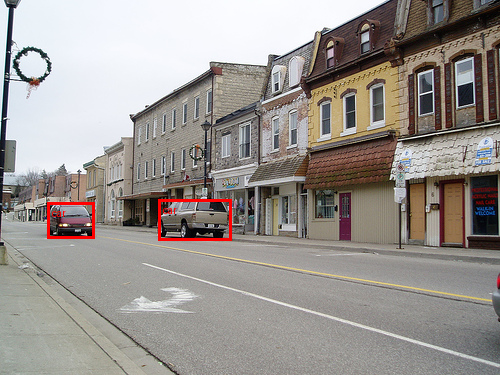

In [9]:
# 画框工具
draw=ImageDraw.Draw(img)

# 遍历每个object
for obj in label['annotation']['object']:
    box=obj['bndbox']
    draw.rectangle([int(box['xmin']),int(box['ymin']),int(box['xmax']),int(box['ymax'])],
                   outline='red',
                   width=3)
    draw.text([int(box['xmin'])+5,int(box['ymin'])+5],obj['name'],fill='red')

img

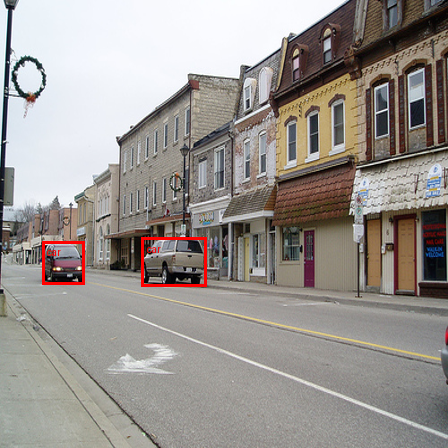

In [10]:
img,label=voc_ds[4]

scaled_img=img.resize((IMG_SIZE,IMG_SIZE)) # 缩放至YoloV1的尺寸

# 缩放比
x_scale=IMG_SIZE/img.width
y_scale=IMG_SIZE/img.height

draw=ImageDraw.Draw(scaled_img)
for obj in label['annotation']['object']:
    box=obj['bndbox']
    draw.rectangle([int(box['xmin'])*x_scale,int(box['ymin'])*y_scale,int(box['xmax'])*x_scale,int(box['ymax'])*y_scale],
                   outline='red',
                   width=3)
    draw.text([int(box['xmin'])*x_scale+5,int(box['ymin'])*y_scale+5],obj['name'],fill='red')

scaled_img

# Dataset设计

In [11]:
# 引入dataset基类
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import torch

In [24]:
class YoloVOCDataset(Dataset):
    def __init__(self,voc_ds):
        super().__init__()
        self.voc_ds=voc_ds
        
        classdict=set()
        for _,label in self.voc_ds:
            for obj in label['annotation']['object']:
                classdict.add(obj['name'])
        self.id2name={i:c for i,c in enumerate(classdict)}
        self.name2id={c:i for i,c in self.id2name.items()}
    
    def __getitem__(self,index):
        img,label=self.voc_ds[index]
        
        scaled_img=img.resize((IMG_SIZE,IMG_SIZE)) 
    
        x_scale=IMG_SIZE/img.width
        y_scale=IMG_SIZE/img.height
        grid_size=IMG_SIZE//S
        
        x=ToTensor()(scaled_img)
        y=torch.zeros(S,S,10+C)
        
        for obj in label['annotation']['object']:
            box=obj['bndbox']
            classid=self.name2id[obj['name']]
            
            # normal coordinates
            xmin,ymin,xmax,ymax=int(box['xmin'])*x_scale,int(box['ymin'])*y_scale,int(box['xmax'])*x_scale,int(box['ymax'])*y_scale
            xcenter,ycenter=(xmin+xmax)/2,(ymin+ymax)/2
            width,height=xmax-xmin,ymax-ymin
            grid_i,grid_j=int(xcenter//grid_size),int(ycenter//grid_size)
            
            # yolo coordinates
            xcenter,ycenter=xcenter%grid_size/grid_size,ycenter%grid_size/grid_size
            width,height=width/IMG_SIZE,height/IMG_SIZE
            
            # targets
            y[grid_i,grid_j,0:5]=y[grid_i,grid_j,5:10]=torch.tensor([xcenter,ycenter,width,height,1])   # x,y,w,h,c
            y[grid_i,grid_j,10:]=torch.zeros(20)
            y[grid_i,grid_j,10+classid]=1
        return x,y
    
    def __len__(self):
        return len(self.voc_ds)

In [25]:
ds=YoloVOCDataset(voc_ds)

In [26]:
x,y=ds[0]
x.shape,y.shape

(torch.Size([3, 448, 448]), torch.Size([7, 7, 30]))

# YoloV1 Model

In [18]:
from torch import nn 
import torch

device='cuda' if torch.cuda.is_available() else 'cpu'

In [124]:
class YoloV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.seq=nn.Sequential(
            # 448*448
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=7,stride=2,padding=3), 
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            # 112*112
            nn.Conv2d(in_channels=64,out_channels=192,kernel_size=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            # 56*56
            nn.Conv2d(in_channels=192,out_channels=128,kernel_size=1,stride=1),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.Conv2d(in_channels=256,out_channels=256,kernel_size=1,stride=1),
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            # 28*28
            *[
                nn.Conv2d(in_channels=512,out_channels=256,kernel_size=1,stride=1),
                nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
            ]*4,
            nn.Conv2d(in_channels=512,out_channels=512,kernel_size=1,stride=1),
            nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,stride=1,padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2),
            
            # 14*14
            *[
                nn.Conv2d(in_channels=1024,out_channels=512,kernel_size=1,stride=1),
                nn.Conv2d(in_channels=512,out_channels=1024,kernel_size=3,stride=1,padding=1),
            ]*2,
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1),
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=2,padding=1),
            
            # 7*7
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1),
            nn.Conv2d(in_channels=1024,out_channels=1024,kernel_size=3,stride=1,padding=1),
            
            nn.Flatten(),
            nn.Linear(in_features=7*7*1024,out_features=4096),
            nn.Linear(in_features=4096,out_features=S*S*(10+C)),
        )
        
    def forward(self,x): # x:(batch,3,448,448)
        y=self.seq(x)
        return torch.reshape(y,(-1,S,S,10+C)) # (7,7,30)

In [125]:
model=YoloV1().to(device)
x,y=ds[0]
outputs=model(x.unsqueeze(0).to(device))
outputs.shape

torch.Size([1, 7, 7, 30])